**Question 1**

In [96]:
import sys
sys.path.append("../")

import numpy as np
from itertools import islice
import matplotlib.pyplot as plt
import scipy.interpolate as inter
from scipy.stats import norm
from rl.function_approx import *
from dataclasses import dataclass, replace, field
from typing import Callable, Tuple, List, Sequence, Iterable, TypeVar, Iterator
from operator import itemgetter
from collections import defaultdict

X = TypeVar('X')

@dataclass(frozen=True)
class BSplineApprox(FunctionApprox[X]):
    degree : int = 3
    feature_function : Callable[[X], float] = lambda x : x
    coefficients : np.ndarray = np.ndarray([])
    knots : np.ndarray = np.ndarray([])

    def get_feature(self, x_seq : Iterable[X]) -> Sequence[float]:
        return [self.feature_function(x) for x in x_seq]

    def solve(self, xy_seq : Iterable[Tuple[X, float]]) : #-> BSplineApprox[X]:
        '''
        this will calculate the new knots and 
        coefficients for our spline when called
        '''
        return self.update(xy_seq)

    def update(self, xy_seq : Iterable[Tuple[X, float]]) : #-> BSplineApprox[X]:
        '''
        first create our feature, sort the pairs
        and then create a new spline and return
        the resulting knots/coefficients
        '''
        x, y = zip(*xy_seq)
        f : List[float] = self.get_feature(x)
        pairs : Sequence[Tuple[float, float]] = sorted(zip(f, y), key = lambda x : x[0])
        new_k, new_c, _ = inter.splrep([x for x, _ in pairs], [y for _, y in pairs], k = self.degree)

        return replace(self, knots=new_k, coefficients=new_c)

    def evaluate(self, x_seq : Iterable[X]) -> np.ndarray:
        '''
        evaluate the spline at the given values 
        '''
        spline = inter.BSpline(t = self.knots, c = self.coefficients, k = self.degree)
        return spline(self.get_feature(x_seq))
    
    def within(self, other : FunctionApprox[X], tolerance : float) -> bool:
        if isinstance(other, BSplineApprox):
            return np.all(np.abs(self.knots - other.knots) <= tolerance).item() \
                and np.all(np.abs(self.coefficients - other.coefficients) <= tolerance).item()

        return False

    def __add__(self, other):
        return replace(self, knots = self.knots, coefficients = self.coefficients + other.coefficients, degree = self.degree)

    def __mul__(self, scalar : float):
        return replace(self, knots = self.knots, coefficients = scalar * self.coefficients, degree = self.degree)

    def objective_gradient(self, xy_seq, obj_deriv_out_func):
        pass

    def update_with_gradient(self, gradient):
        pass


In [97]:
data = [(x,10*np.sin(x/10)*np.random.randn()) for x in range(100)]
test_data = [(x,50*np.sin(x/10)+np.random.randn()/3) for x in range(100)]

x_train = [ele[0] for ele in data]
y_train = [ele[1] for ele in data]
y_test = [ele[1] for ele in test_data]

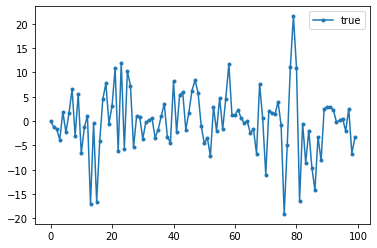

In [98]:
from matplotlib import pyplot as plt
plt.plot(x_train,y_train,'.-',label='true')
plt.legend()
plt.show()

In [99]:
spline_approx = BSplineApprox(feature_function=lambda x : x, degree=1).update(data)

predicted = spline_approx.evaluate([x for x, _ in test_data])

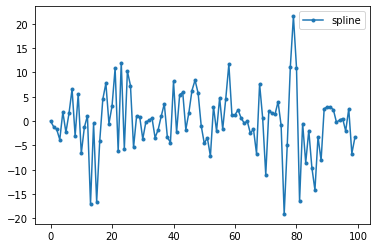

In [100]:
plt.plot(x_train,predicted,'.-',label='spline')
plt.legend()
plt.show()

In [101]:
print("RMSE of fit")
np.sqrt(sum((y_test-predicted)**2))/len(y_test)

RMSE of fit


3.592606483217127